# Load libraries

In [137]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib scikit-learn seaborn umap-learn scipy xgboost shap PyALE


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [138]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Ensure this is imported
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import math
import json
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import shap
from PyALE import ale
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress, spearmanr

# Loading the data

In [149]:
chamau_lag = pd.read_csv("../datasets/Chamau_2014-2024_clean.csv")
chamau_daily = pd.read_csv("../datasets/Chamau_Daily_2014-2024.csv")
oensingen_1_lag = pd.read_csv("../datasets/Oensingen_2018-19_clean.csv")
oensingen_1_daily = pd.read_csv("../datasets/Oensingen_Daily_2018-19.csv")
oensingen_2_lag = pd.read_csv("../datasets/Oensingen_2021-23_clean.csv")
oensingen_2_daily = pd.read_csv("../datasets/Oensingen_Daily_2021-23.csv")
aeschi_lag = pd.read_csv("../datasets/Aeschi_2019-20_clean.csv")
aeschi_daily = pd.read_csv("../datasets/Aeschi_Daily_2019-20.csv")
forel_lag = pd.read_csv("../datasets/Forel_2024-25_clean.csv")
forel_daily = pd.read_csv("../datasets/Forel_Daily_2024-25.csv")
tanikon_lag = pd.read_csv("../datasets/Tanikon_2023-25_clean.csv")
tanikon_daily = pd.read_csv("../datasets/Tanikon_Daily_2023-25.csv")

# Experiment 1: Oensingen 2018-19

In [107]:
# FIX TIMESTAMP
oensingen_1_lag['Timestamp'] = pd.to_datetime(oensingen_1_lag['Timestamp'])
oensingen_1_lag = oensingen_1_lag.set_index('Timestamp').sort_index()

oensingen_1_daily['Date'] = pd.to_datetime(oensingen_1_daily['Date'])
oensingen_1_daily = oensingen_1_daily.sort_values('Date')


# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": oensingen_1_lag,
    "Daily": oensingen_1_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [108]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.8)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-0.131, ρ=0.327

Hourly | N2O_Flux | lag
  R²=-0.274, ρ=0.323

Hourly | N2O_Flux | main
  R²=-0.602, ρ=-0.012

Hourly | N2O_Flux_ln | base
  R²=-0.164, ρ=0.319

Hourly | N2O_Flux_ln | lag
  R²=-0.045, ρ=0.308

Hourly | N2O_Flux_ln | main
  R²=-0.421, ρ=-0.006

Daily | N2O_Flux | base
  R²=-10.001, ρ=0.366

Daily | N2O_Flux | lag
  R²=-4.658, ρ=0.464

Daily | N2O_Flux | main
  R²=-1.350, ρ=-0.081

Daily | N2O_Flux_ln | base
  R²=-5.707, ρ=0.356

Daily | N2O_Flux_ln | lag
  R²=-2.631, ρ=0.475

Daily | N2O_Flux_ln | main
  R²=-0.618, ρ=-0.019

=== Summary Results ===
   Dataset       Target Predictors      R2  Spearman
0   Hourly     N2O_Flux       base  -0.131     0.327
1   Hourly     N2O_Flux        lag  -0.274     0.323
2   Hourly     N2O_Flux       main  -0.602    -0.012
3   Hourly  N2O_Flux_ln       base  -0.164     0.319
4   Hourly  N2O_Flux_ln        lag  -0.045     0.308
5   Hourly  N2O_Flux_ln       main  -0.421    -0.006
6    Daily     N2O_Flux    

In [109]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

--- Training on oensingen_1_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 0 → 62
Test  period: 63 → 164

Model evaluation:
  R² (linear scale): -25.514
  Spearman ρ:        0.000


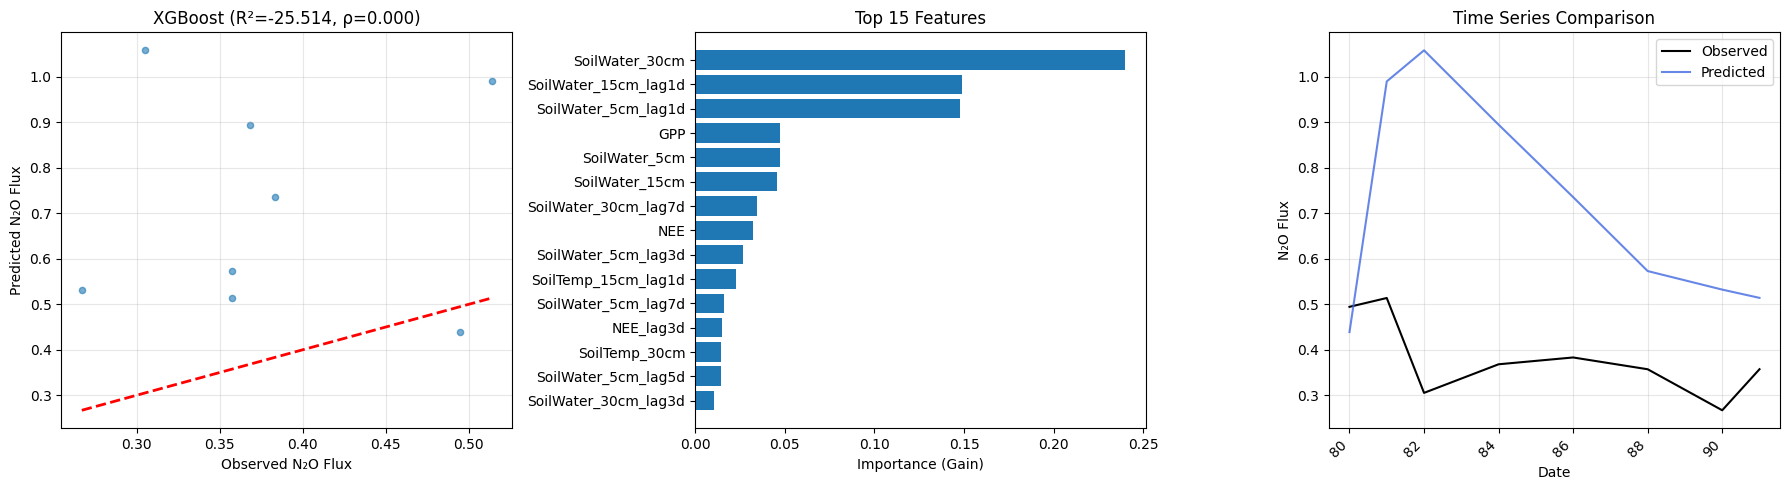


main cols
Train period: 2018-07-12 07:45:00 → 2019-09-13 16:45:00
Test  period: 2019-09-13 17:15:00 → 2019-10-04 23:15:00

Model evaluation:
  R² (linear scale): -0.391
  Spearman ρ:        -0.282


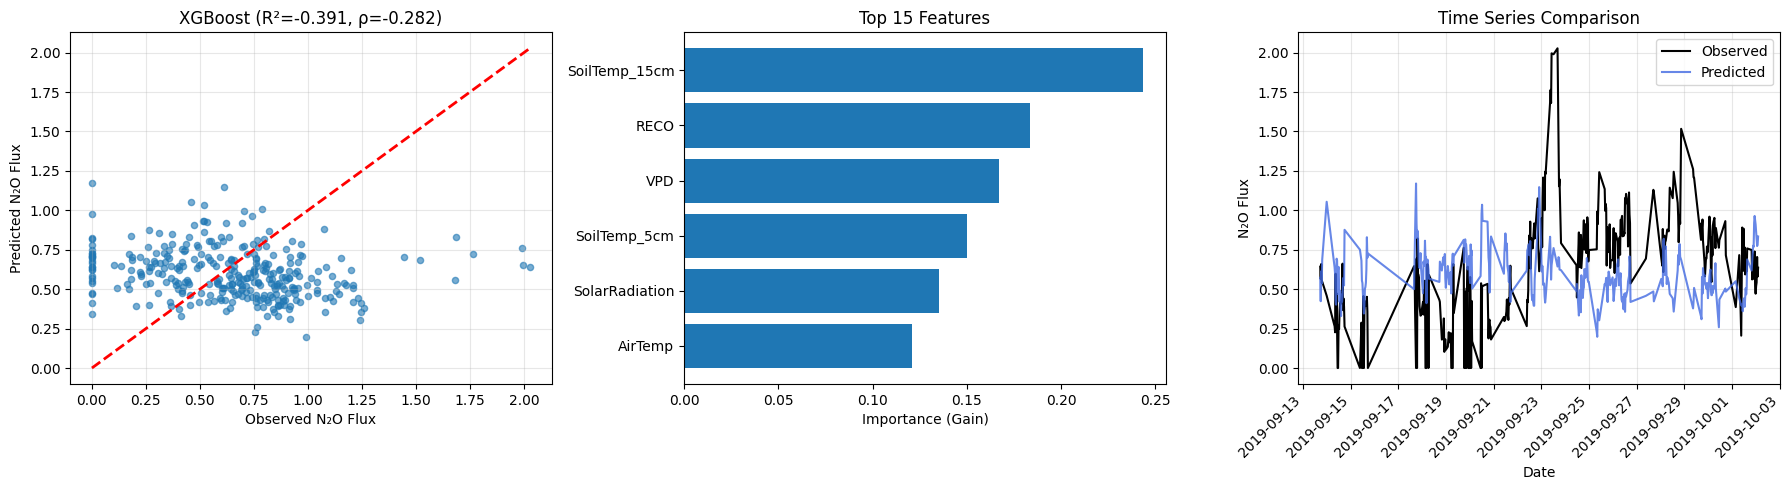


TOP 20 MOST IMPORTANT FEATURES:
SoilTemp_15cm     0.243330
RECO              0.183497
VPD               0.167171
SoilTemp_5cm      0.150239
SolarRadiation    0.134980
AirTemp           0.120783
dtype: float32


In [110]:
# ============================================================================
# TRAINING 1: oensingen_1_daily with lag features
# ============================================================================

print("--- Training on oensingen_1_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_xgb_timeseries(
    df=oensingen_1_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_SoilCultivation"
    ],
    target="N2O_Flux_ln",
)


# ============================================================================
# TRAINING 2: oensingen 1 (hourly) with main columns only
# ============================================================================

print("\nmain cols")
results = train_xgb_timeseries(
    df=oensingen_1_lag,
    predictors=[
        "AirTemp", "VPD",
        "SoilTemp_5cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

# PRINT TOP FEATURES FROM LAST MODEL
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
print(results["feature_importance"].head(20))

# Experiment 2: Oensingen 2021-23

In [111]:
# FIX TIMESTAMP
oensingen_2_lag['Timestamp'] = pd.to_datetime(oensingen_2_lag['Timestamp'])
oensingen_2_lag = oensingen_2_lag.set_index('Timestamp').sort_index()

oensingen_2_daily['Date'] = pd.to_datetime(oensingen_2_daily['Date'])
oensingen_2_daily = oensingen_2_daily.sort_values('Date')


# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": oensingen_2_lag,
    "Daily": oensingen_2_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [112]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.9)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-0.062, ρ=0.494

Hourly | N2O_Flux | lag
  R²=-0.417, ρ=0.315

Hourly | N2O_Flux | main
  R²=-1.809, ρ=-0.022

Hourly | N2O_Flux_ln | base
  R²=0.008, ρ=0.356

Hourly | N2O_Flux_ln | lag
  R²=-0.242, ρ=0.227

Hourly | N2O_Flux_ln | main
  R²=-0.590, ρ=-0.095

Daily | N2O_Flux | base
  R²=0.516, ρ=0.831

Daily | N2O_Flux | lag
  R²=0.306, ρ=0.776

Daily | N2O_Flux | main
  R²=-0.822, ρ=0.216

Daily | N2O_Flux_ln | base
  R²=0.649, ρ=0.869

Daily | N2O_Flux_ln | lag
  R²=0.335, ρ=0.757

Daily | N2O_Flux_ln | main
  R²=-0.511, ρ=0.125

=== Summary Results ===
   Dataset       Target Predictors     R2  Spearman
0   Hourly     N2O_Flux       base -0.062     0.494
1   Hourly     N2O_Flux        lag -0.417     0.315
2   Hourly     N2O_Flux       main -1.809    -0.022
3   Hourly  N2O_Flux_ln       base  0.008     0.356
4   Hourly  N2O_Flux_ln        lag -0.242     0.227
5   Hourly  N2O_Flux_ln       main -0.590    -0.095
6    Daily     N2O_Flux       base  0.516 

In [113]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

--- Training on oensingen_2_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 0 → 284
Test  period: 285 → 373

Model evaluation:
  R² (linear scale): 0.335
  Spearman ρ:        0.757


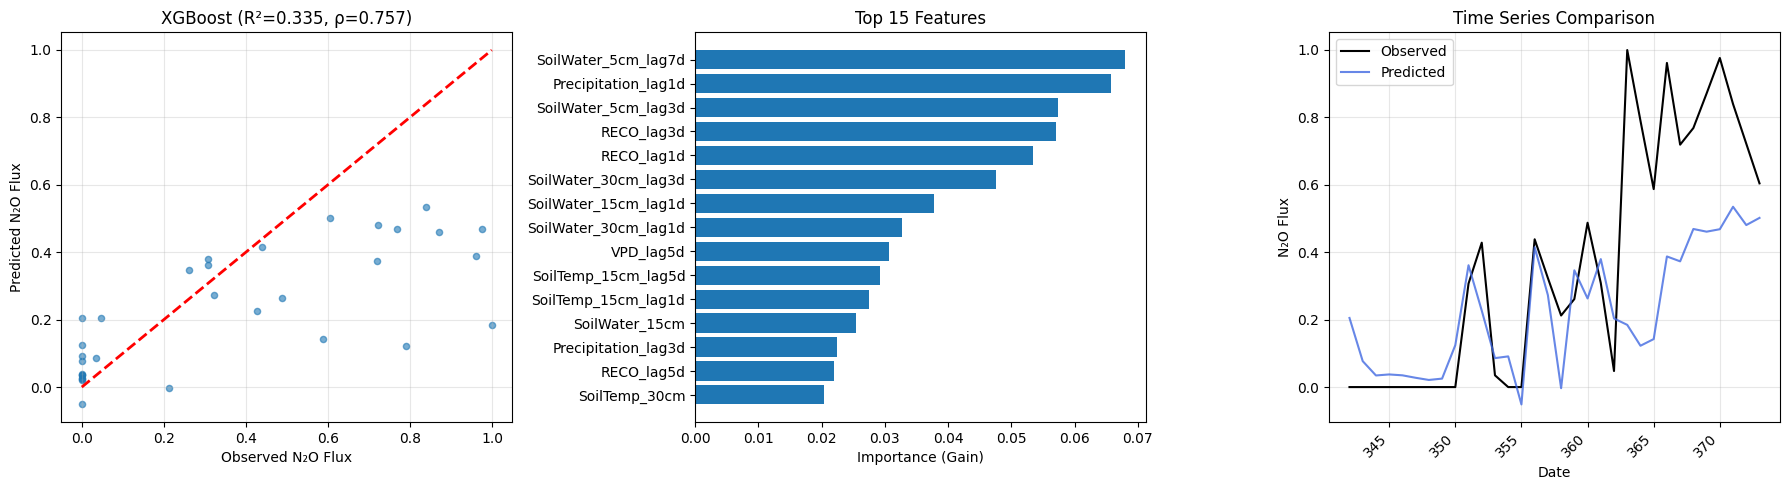


main cols
Train period: 2022-08-30 11:45:00 → 2023-08-20 21:45:00
Test  period: 2023-08-21 17:15:00 → 2023-10-05 12:15:00

Model evaluation:
  R² (linear scale): -0.590
  Spearman ρ:        -0.095


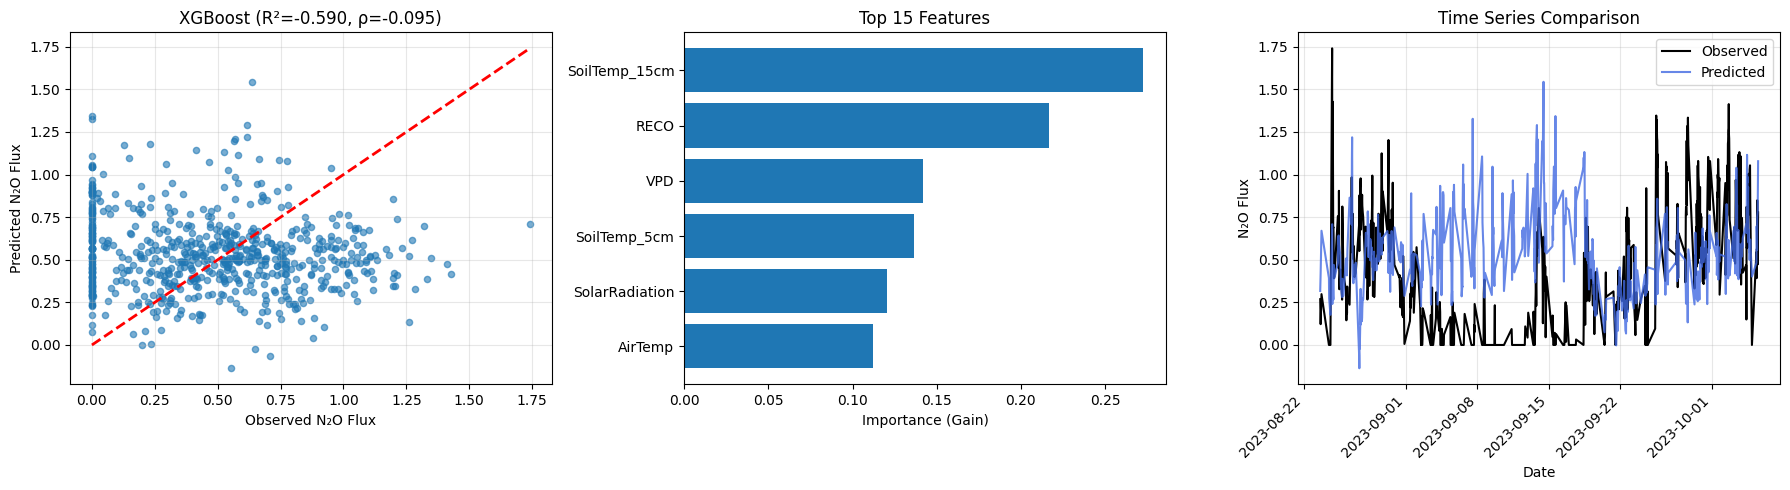


TOP 20 MOST IMPORTANT FEATURES:
SoilTemp_15cm     0.272463
RECO              0.216606
VPD               0.141801
SoilTemp_5cm      0.136338
SolarRadiation    0.120608
AirTemp           0.112184
dtype: float32


In [114]:
# ============================================================================
# TRAINING 1: oensingen_2_daily with lag features
# ============================================================================

print("--- Training on oensingen_2_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_xgb_timeseries(
    df=oensingen_2_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_SoilCultivation"
    ],
    target="N2O_Flux_ln",
)


# ============================================================================
# TRAINING 2: oensingen 2 (hourly) with main columns only
# ============================================================================

print("\nmain cols")
results = train_xgb_timeseries(
    df=oensingen_2_lag,
    predictors=[
        "AirTemp", "VPD",
        "SoilTemp_5cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

# PRINT TOP FEATURES FROM LAST MODEL
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
print(results["feature_importance"].head(20))

# Experiment 3: Aeschi dataset

In [115]:
# FIX TIMESTAMP
aeschi_lag['Timestamp'] = pd.to_datetime(aeschi_lag['Timestamp'])
aeschi_lag = aeschi_lag.set_index('Timestamp').sort_index()

aeschi_daily['Date'] = pd.to_datetime(aeschi_daily['Date'])
aeschi_daily = aeschi_daily.set_index('Date').sort_index()

# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO", "Mowing"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": aeschi_lag,
    "Daily": aeschi_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [116]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.9)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-2.236, ρ=0.139

Hourly | N2O_Flux | lag
  R²=-0.606, ρ=0.140

Hourly | N2O_Flux | main
  R²=-3.195, ρ=0.077

Hourly | N2O_Flux_ln | base
  R²=-2.066, ρ=0.080

Hourly | N2O_Flux_ln | lag
  R²=-0.434, ρ=0.103

Hourly | N2O_Flux_ln | main
  R²=-1.772, ρ=0.100

Daily | N2O_Flux | base
  R²=-3.423, ρ=0.357

Daily | N2O_Flux | lag
  R²=-13.363, ρ=0.257

Daily | N2O_Flux | main
  R²=-4.736, ρ=0.000

Daily | N2O_Flux_ln | base
  R²=-2.135, ρ=0.214

Daily | N2O_Flux_ln | lag
  R²=-2.167, ρ=0.143

Daily | N2O_Flux_ln | main
  R²=0.309, ρ=0.429

=== Summary Results ===
   Dataset       Target Predictors      R2  Spearman
0   Hourly     N2O_Flux       base  -2.236     0.139
1   Hourly     N2O_Flux        lag  -0.606     0.140
2   Hourly     N2O_Flux       main  -3.195     0.077
3   Hourly  N2O_Flux_ln       base  -2.066     0.080
4   Hourly  N2O_Flux_ln        lag  -0.434     0.103
5   Hourly  N2O_Flux_ln       main  -1.772     0.100
6    Daily     N2O_Flux       ba

In [117]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

--- Training on aeschi_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 2019-07-03 00:00:00 → 2020-10-13 00:00:00
Test  period: 2020-10-14 00:00:00 → 2020-11-02 00:00:00

Model evaluation:
  R² (linear scale): -2.167
  Spearman ρ:        0.143


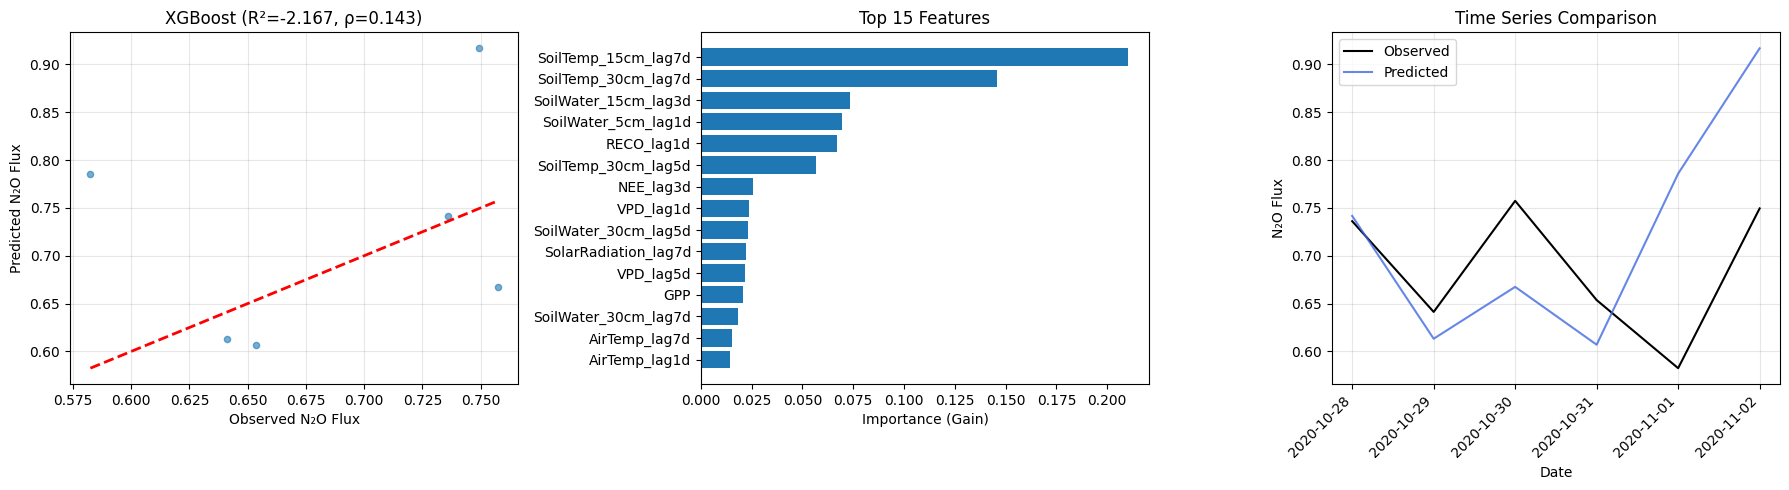


main cols
Train period: 2019-07-03 14:45:00 → 2020-10-27 03:15:00
Test  period: 2020-10-27 03:45:00 → 2020-11-02 17:45:00

Model evaluation:
  R² (linear scale): -1.772
  Spearman ρ:        0.100


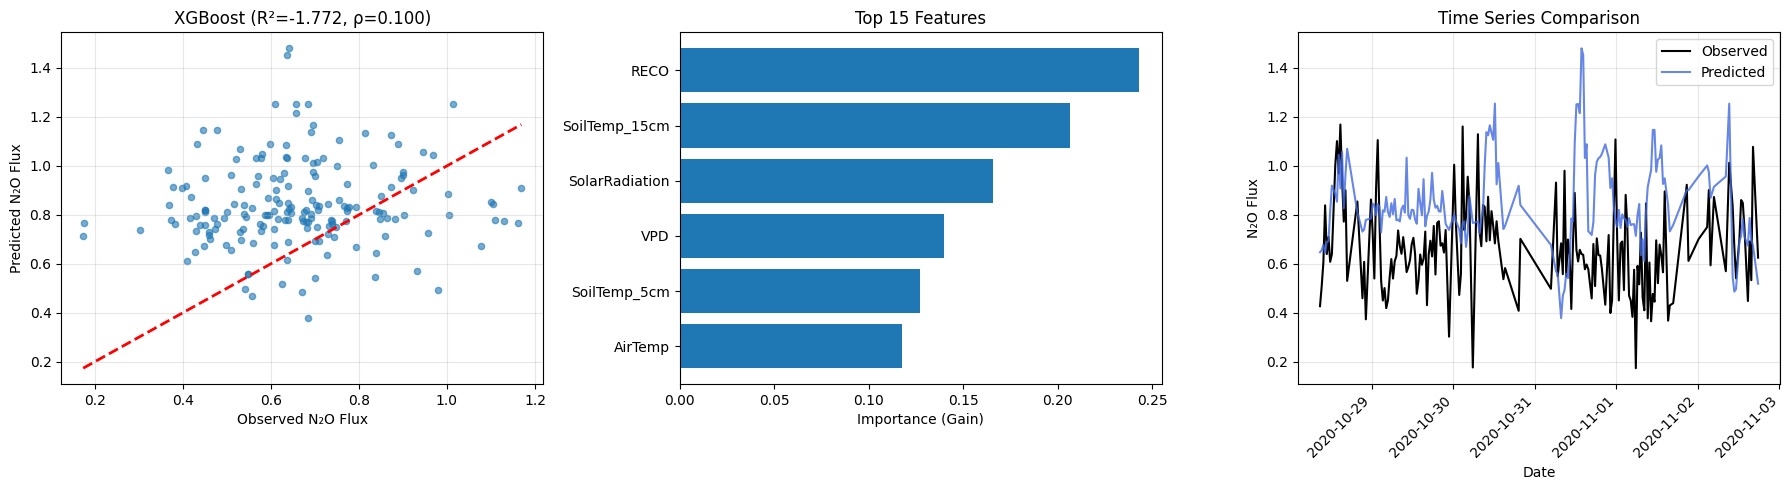


TOP 20 MOST IMPORTANT FEATURES:
RECO              0.242788
SoilTemp_15cm     0.206540
SolarRadiation    0.165793
VPD               0.139924
SoilTemp_5cm      0.127350
AirTemp           0.117604
dtype: float32


In [118]:
# ============================================================================
# TRAINING 1: aeschi_daily with lag features
# ============================================================================

print("--- Training on aeschi_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_xgb_timeseries(
    df=aeschi_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing",
    ],
    target="N2O_Flux_ln",
)


# ============================================================================
# TRAINING 2: aeschi (hourly) with main columns only
# ============================================================================

print("\nmain cols")
results = train_xgb_timeseries(
    df=aeschi_lag,
    predictors=[
        "AirTemp", "VPD",
        "SoilTemp_5cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

# PRINT TOP FEATURES FROM LAST MODEL
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
print(results["feature_importance"].head(20))

# Experiment 4: Chamau dataset

In [100]:
# FIX TIMESTAMP
chamau_lag['Timestamp'] = pd.to_datetime(chamau_lag['Timestamp'])
chamau_lag = chamau_lag.set_index('Timestamp').sort_index()

chamau_daily['Date'] = pd.to_datetime(chamau_daily['Date'])
chamau_daily = chamau_daily.sort_values('Date')

# SPLIT BY PARCEL
chamau_A = chamau_lag[chamau_lag['Parcel'] == 'A'].copy()
chamau_B = chamau_lag[chamau_lag['Parcel'] == 'B'].copy()
chamau_daily_A = chamau_daily[chamau_daily['Parcel'] == 'A'].set_index('Date')
chamau_daily_B = chamau_daily[chamau_daily['Parcel'] == 'B'].set_index('Date')

# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_4cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": chamau_lag,
    "Hourly A": chamau_A,
    "Hourly B": chamau_B,
    "Daily A": chamau_daily_A,
    "Daily B": chamau_daily_B,
    "Daily": chamau_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [101]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.9)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-0.023, ρ=0.299

Hourly | N2O_Flux | lag
  R²=0.011, ρ=0.500

Hourly | N2O_Flux | main
  R²=0.061, ρ=0.402

Hourly | N2O_Flux_ln | base
  R²=0.156, ρ=0.397

Hourly | N2O_Flux_ln | lag
  R²=0.048, ρ=0.388

Hourly | N2O_Flux_ln | main
  R²=0.226, ρ=0.449

Hourly A | N2O_Flux | base
  R²=0.072, ρ=0.563

Hourly A | N2O_Flux | lag
  R²=0.008, ρ=0.575

Hourly A | N2O_Flux | main
  R²=-0.004, ρ=0.482

Hourly A | N2O_Flux_ln | base
  R²=0.311, ρ=0.609

Hourly A | N2O_Flux_ln | lag
  R²=0.196, ρ=0.695

Hourly A | N2O_Flux_ln | main
  R²=0.183, ρ=0.497

Hourly B | N2O_Flux | base
  R²=-0.095, ρ=0.370

Hourly B | N2O_Flux | lag
  R²=-0.264, ρ=0.420

Hourly B | N2O_Flux | main
  R²=0.163, ρ=0.475

Hourly B | N2O_Flux_ln | base
  R²=0.067, ρ=0.309

Hourly B | N2O_Flux_ln | lag
  R²=0.296, ρ=0.611

Hourly B | N2O_Flux_ln | main
  R²=0.250, ρ=0.471

Daily A | N2O_Flux | base
  R²=0.009, ρ=0.433

Daily A | N2O_Flux | lag
  R²=0.362, ρ=0.598

Daily A | N2O_Flux | main
  R

In [102]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

--- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 0 → 2135
Test  period: 2136 → 2907

Model evaluation:
  R² (linear scale): 0.583
  Spearman ρ:        0.666


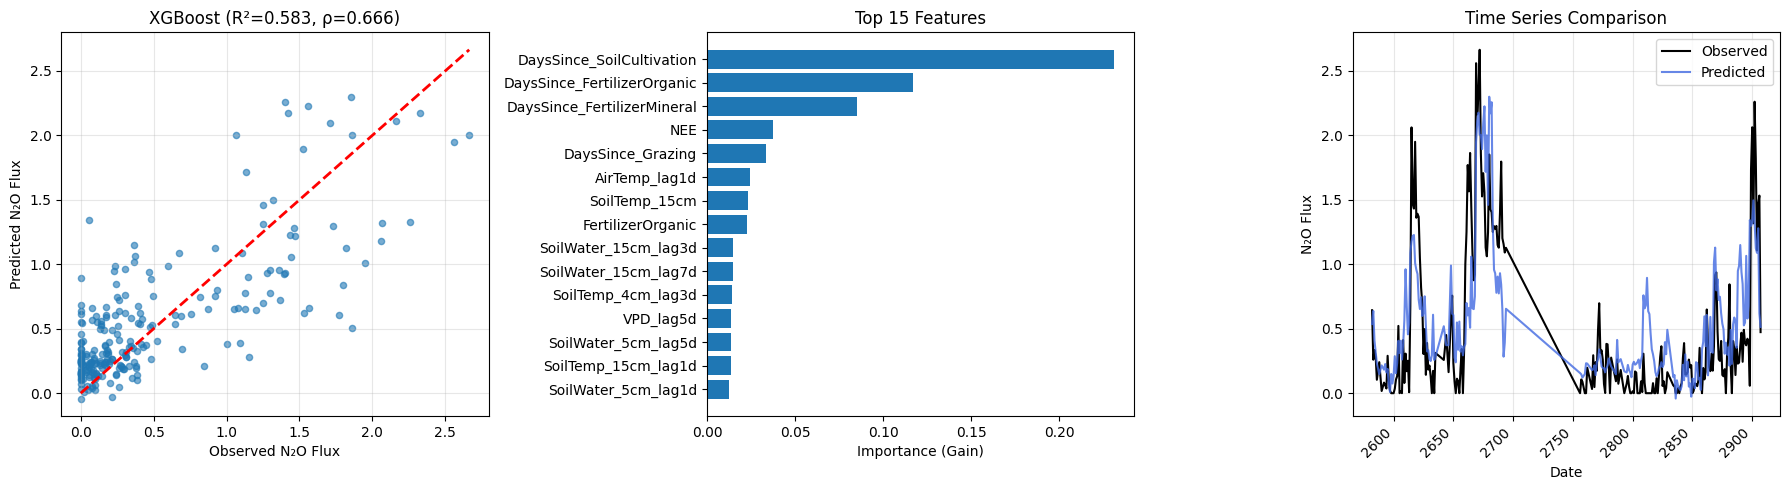


main cols
Train period: 0 → 13816
Test  period: 13817 → 15850

Model evaluation:
  R² (linear scale): 0.226
  Spearman ρ:        0.449


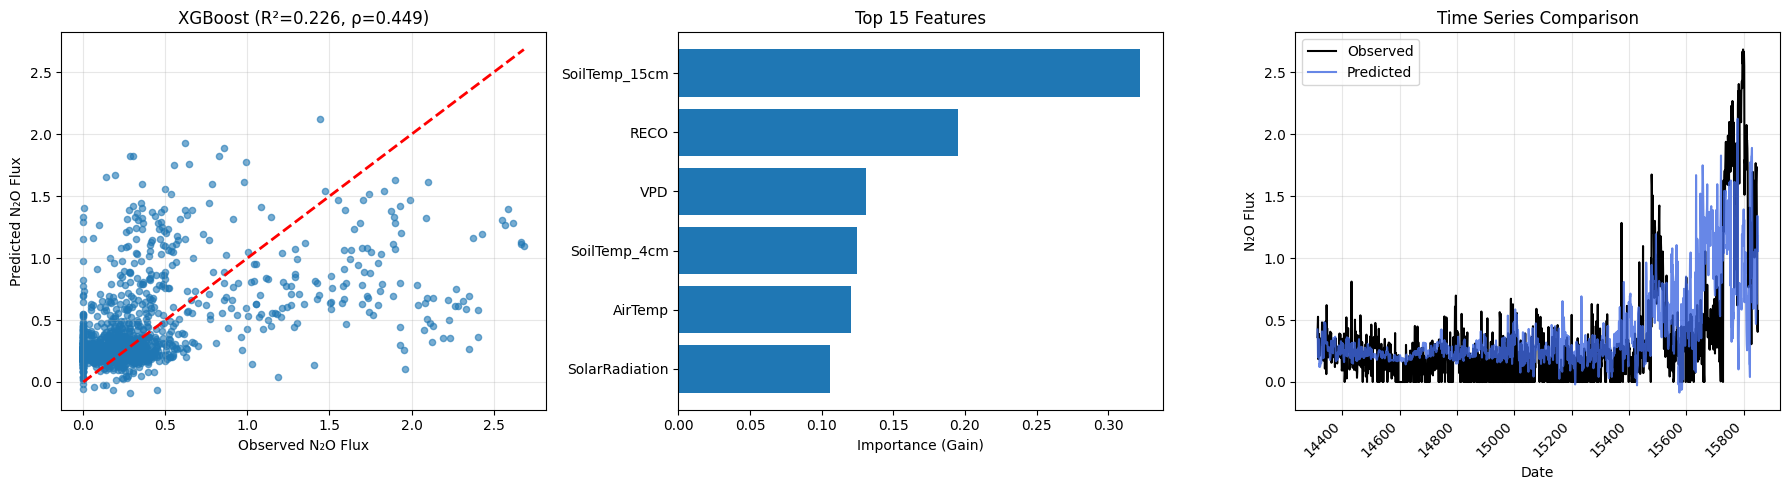


TOP 20 MOST IMPORTANT FEATURES:
SoilTemp_15cm     0.322086
RECO              0.195325
VPD               0.131212
SoilTemp_4cm      0.124590
AirTemp           0.120683
SolarRadiation    0.106103
dtype: float32


In [119]:
# ============================================================================
# TRAINING 1: chamau_daily with lag features
# ============================================================================

print("--- Training on chamau_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_xgb_timeseries(
    df=chamau_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilTemp_4cm_lag1d", "SoilTemp_4cm_lag3d", "SoilTemp_4cm_lag5d", "SoilTemp_4cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
        "DaysSince_Grazing", "DaysSince_SoilCultivation"
    ],
    target="N2O_Flux_ln",
)


# ============================================================================
# TRAINING 2: chamau (hourly) with main columns only
# ============================================================================

print("\nmain cols")
results = train_xgb_timeseries(
    df=chamau_lag,
    predictors=[
        "AirTemp", "VPD",
        "SoilTemp_4cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

# PRINT TOP FEATURES FROM LAST MODEL
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
print(results["feature_importance"].head(20))

# Experiment 5: Forel

In [124]:
# FIX TIMESTAMP
forel_lag['Timestamp'] = pd.to_datetime(forel_lag['Timestamp'])
forel_lag = forel_lag.set_index('Timestamp').sort_index()

forel_daily['Date'] = pd.to_datetime(forel_daily['Date'])
forel_daily = forel_daily.sort_values('Date')


# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", 
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": forel_lag,
    "Daily": forel_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [134]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.8)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-1.573, ρ=0.194

Hourly | N2O_Flux | lag
  R²=-0.574, ρ=0.302

Hourly | N2O_Flux | main
  R²=-0.625, ρ=0.221

Hourly | N2O_Flux_ln | base
  R²=-1.224, ρ=0.244

Hourly | N2O_Flux_ln | lag
  R²=-0.612, ρ=0.268

Hourly | N2O_Flux_ln | main
  R²=-0.522, ρ=0.274

Daily | N2O_Flux | base
  R²=-2.563, ρ=0.394

Daily | N2O_Flux | lag
  R²=-0.033, ρ=0.377

Daily | N2O_Flux | main
  R²=-1.387, ρ=0.297

Daily | N2O_Flux_ln | base
  R²=-0.584, ρ=0.470

Daily | N2O_Flux_ln | lag
  R²=-0.036, ρ=0.348

Daily | N2O_Flux_ln | main
  R²=-0.549, ρ=0.351

=== Summary Results ===
   Dataset       Target Predictors     R2  Spearman
0   Hourly     N2O_Flux       base -1.573     0.194
1   Hourly     N2O_Flux        lag -0.574     0.302
2   Hourly     N2O_Flux       main -0.625     0.221
3   Hourly  N2O_Flux_ln       base -1.224     0.244
4   Hourly  N2O_Flux_ln        lag -0.612     0.268
5   Hourly  N2O_Flux_ln       main -0.522     0.274
6    Daily     N2O_Flux       base -2.5

In [135]:
def train_xgb_timeseries(df, predictors, target, test_size=0.2, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

--- Training on forel_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 0 → 297
Test  period: 298 → 413

Model evaluation:
  R² (linear scale): -0.036
  Spearman ρ:        0.348


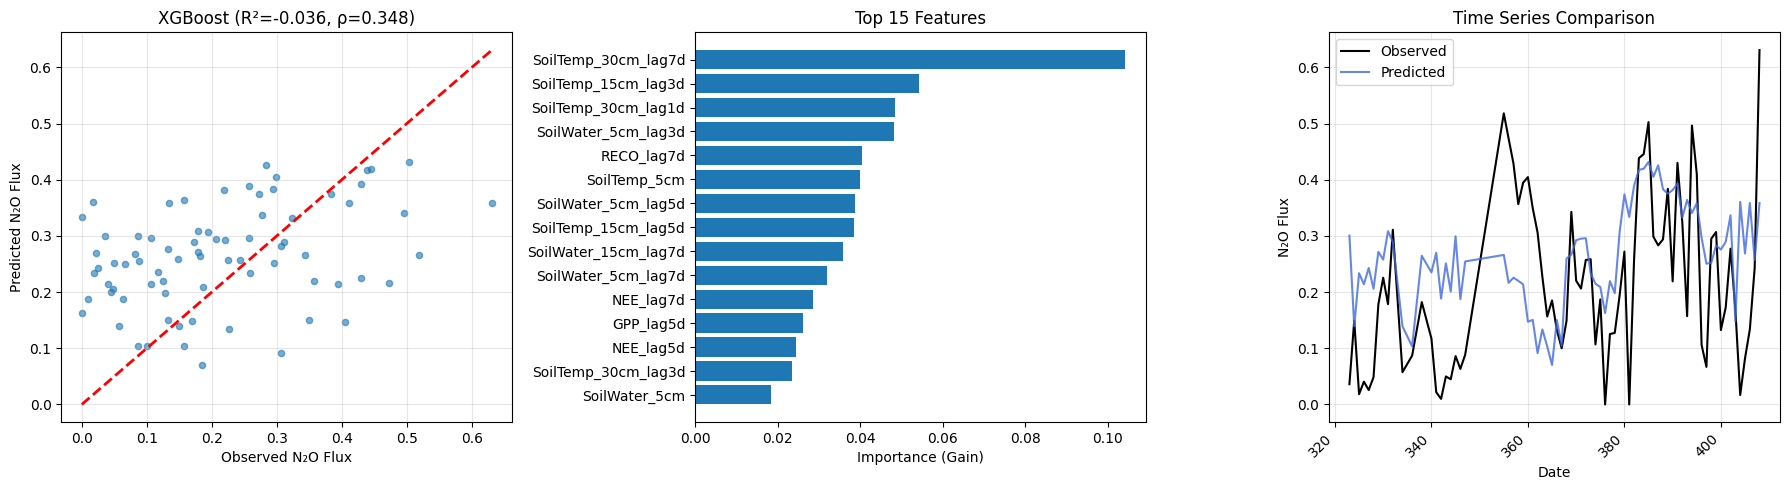


main cols
Train period: 2024-03-07 21:15:00 → 2025-01-18 11:45:00
Test  period: 2025-01-18 12:45:00 → 2025-05-03 13:15:00

Model evaluation:
  R² (linear scale): -0.522
  Spearman ρ:        0.274


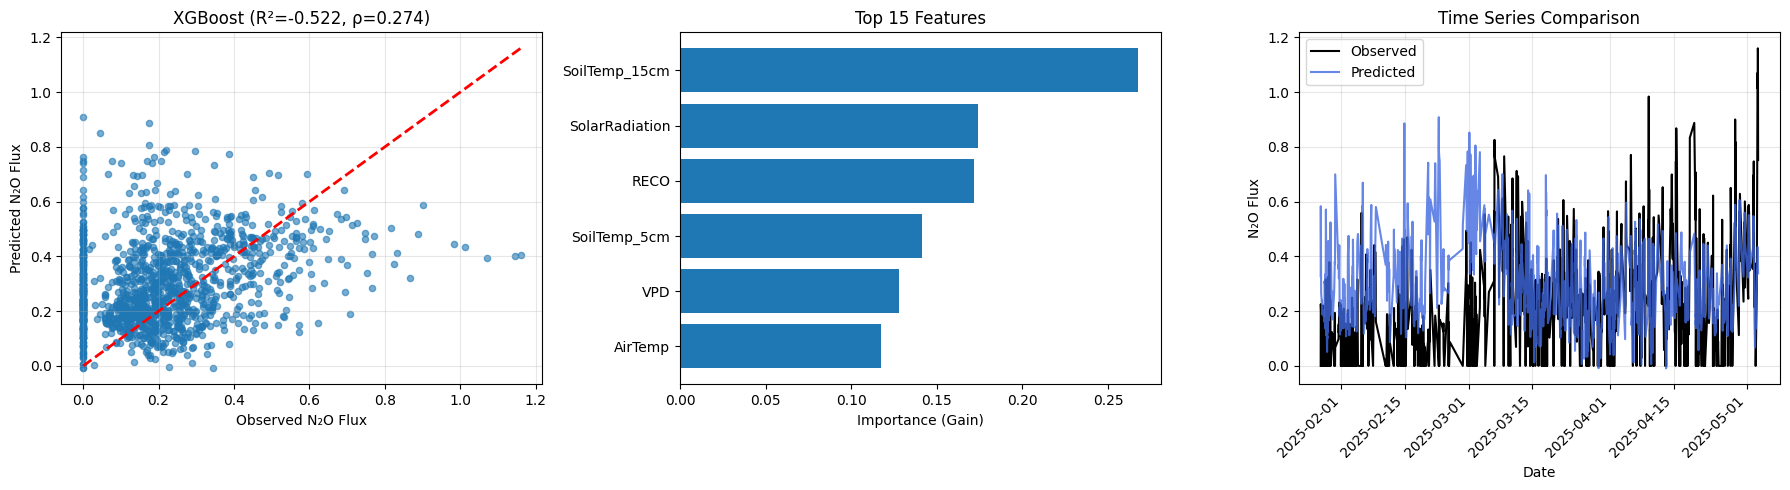


TOP 20 MOST IMPORTANT FEATURES:
SoilTemp_15cm     0.267696
SolarRadiation    0.173952
RECO              0.171756
SoilTemp_5cm      0.141090
VPD               0.128147
AirTemp           0.117359
dtype: float32


In [136]:
# ============================================================================
# TRAINING 1: forel_daily with lag features
# ============================================================================

print("--- Training on forel_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_xgb_timeseries(
    df=forel_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    ],
    target="N2O_Flux_ln",
)


# ============================================================================
# TRAINING 2: forel(hourly) with main columns only
# ============================================================================

print("\nmain cols")
results = train_xgb_timeseries(
    df=forel_lag,
    predictors=[
        "AirTemp", "VPD",
        "SoilTemp_5cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

# PRINT TOP FEATURES FROM LAST MODEL
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
print(results["feature_importance"].head(20))

# Experiment 6: Tanikon

In [150]:
# FIX TIMESTAMP
tanikon_lag['Timestamp'] = pd.to_datetime(tanikon_lag['Timestamp'])
tanikon_lag = tanikon_lag.set_index('Timestamp').sort_index()

tanikon_daily['Date'] = pd.to_datetime(tanikon_daily['Date'])
tanikon_daily = tanikon_daily.sort_values('Date')

# SPLIT BY PARCEL
tanikon_A = tanikon_lag[tanikon_lag['Parcel'] == 'A'].copy()
tanikon_B = tanikon_lag[tanikon_lag['Parcel'] == 'B'].copy()
tanikon_daily_A = tanikon_daily[tanikon_daily['Parcel'] == 'A'].set_index('Date')
tanikon_daily_B = tanikon_daily[tanikon_daily['Parcel'] == 'B'].set_index('Date')

# PREDICTOR SETS
predictor_sets = {
    "base": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation"
    ],
    
    "lag": [
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        'SoilWater_30cm_lag1d', 'SoilWater_30cm_lag3d', 'SoilWater_30cm_lag5d', 'SoilWater_30cm_lag7d',
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        'SoilTemp_30cm_lag1d', 'SoilTemp_30cm_lag3d', 'SoilTemp_30cm_lag5d', 'SoilTemp_30cm_lag7d',
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
        "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral", "DaysSince_SoilCultivation"
    ],
    
    "main": ["AirTemp", "VPD", "SoilTemp_5cm", "SoilTemp_15cm", "RECO", "SolarRadiation"]
}

# DATASETS
datasets = {
    "Hourly": tanikon_lag,
    "Hourly A": tanikon_A,
    "Hourly B": tanikon_B,
    "Daily A": tanikon_daily_A,
    "Daily B": tanikon_daily_B,
    "Daily": tanikon_daily
}

targets = ["N2O_Flux", "N2O_Flux_ln"]

In [151]:
# RUN ALL EXPERIMENTS
results = []

for df_name, df in datasets.items():
    for target in targets:
        for set_name, preds in predictor_sets.items():
            print(f"\n{df_name} | {target} | {set_name}")
            
            try:
                # PREP DATA
                X = df[preds]
                y = df[target]
                mask = X.notna().all(axis=1) & y.notna()
                X, y = X[mask], y[mask]
                
                # OFFSET
                offset = abs(y.min()) + 1e-6
                y = y + offset
                
                # SPLIT
                split = int(len(X) * 0.9)
                X_train, X_test = X.iloc[:split], X.iloc[split:]
                y_train, y_test = y.iloc[:split], y.iloc[split:]
                
                # TRAIN
                model = XGBRegressor(
                    max_depth=6,
                    learning_rate=0.1,
                    n_estimators=300,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    n_jobs=-1
                )
                model.fit(X_train, y_train, verbose=False)
                
                # PREDICT
                y_pred = model.predict(X_test) - offset
                y_test = y_test - offset
                
                # EVALUATE
                r2 = r2_score(y_test, y_pred)
                rho, _ = spearmanr(y_test, y_pred)
                
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": r2,
                    "Spearman": rho
                })
                
                print(f"  R²={r2:.3f}, ρ={rho:.3f}")
                
            except Exception as e:
                print(f"  ERROR: {e}")
                results.append({
                    "Dataset": df_name,
                    "Target": target,
                    "Predictors": set_name,
                    "R2": None,
                    "Spearman": None
                })

# DISPLAY RESULTS
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("=== Summary Results ===")
print(results_df.round(3))


Hourly | N2O_Flux | base
  R²=-8.121, ρ=0.146

Hourly | N2O_Flux | lag
  R²=-5.874, ρ=0.519

Hourly | N2O_Flux | main
  R²=-28.598, ρ=0.051

Hourly | N2O_Flux_ln | base
  R²=-65.989, ρ=0.054

Hourly | N2O_Flux_ln | lag
  R²=-24.829, ρ=0.286

Hourly | N2O_Flux_ln | main
  R²=-20.471, ρ=-0.070

Hourly A | N2O_Flux | base
  R²=-1.616, ρ=0.446

Hourly A | N2O_Flux | lag
  R²=-1.705, ρ=0.639

Hourly A | N2O_Flux | main
  R²=-33.376, ρ=0.498

Hourly A | N2O_Flux_ln | base
  R²=-11.689, ρ=-0.053

Hourly A | N2O_Flux_ln | lag
  R²=-10.939, ρ=0.311

Hourly A | N2O_Flux_ln | main
  R²=-22.192, ρ=-0.116

Hourly B | N2O_Flux | base
  R²=-8.872, ρ=0.007

Hourly B | N2O_Flux | lag
  R²=-8.800, ρ=0.093

Hourly B | N2O_Flux | main
  R²=-7.882, ρ=0.085

Hourly B | N2O_Flux_ln | base
  R²=-21.795, ρ=0.123

Hourly B | N2O_Flux_ln | lag
  R²=-24.173, ρ=0.284

Hourly B | N2O_Flux_ln | main
  R²=-3.923, ρ=0.011

Daily A | N2O_Flux | base
  R²=-13.345, ρ=0.511

Daily A | N2O_Flux | lag
  R²=-31.817, ρ=0.465

In [152]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

--- Training on tanikon_daily | target=N2O_Flux_ln | predictors=lag ---
Train period: 0 → 575
Test  period: 576 → 877

Model evaluation:
  R² (linear scale): -5.114
  Spearman ρ:        -0.067


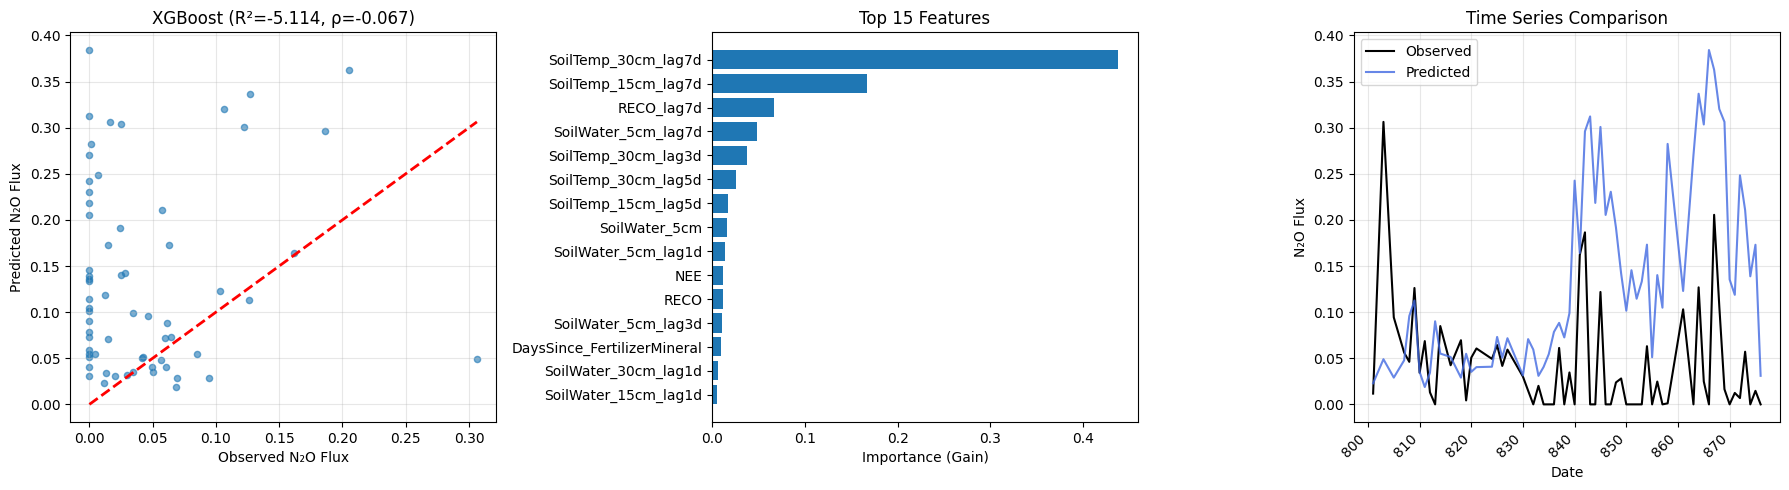


main cols
Train period: 2023-11-07 15:45:00 → 2025-02-17 03:45:00
Test  period: 2025-02-17 04:15:00 → 2025-06-05 00:45:00

Model evaluation:
  R² (linear scale): -20.471
  Spearman ρ:        -0.070


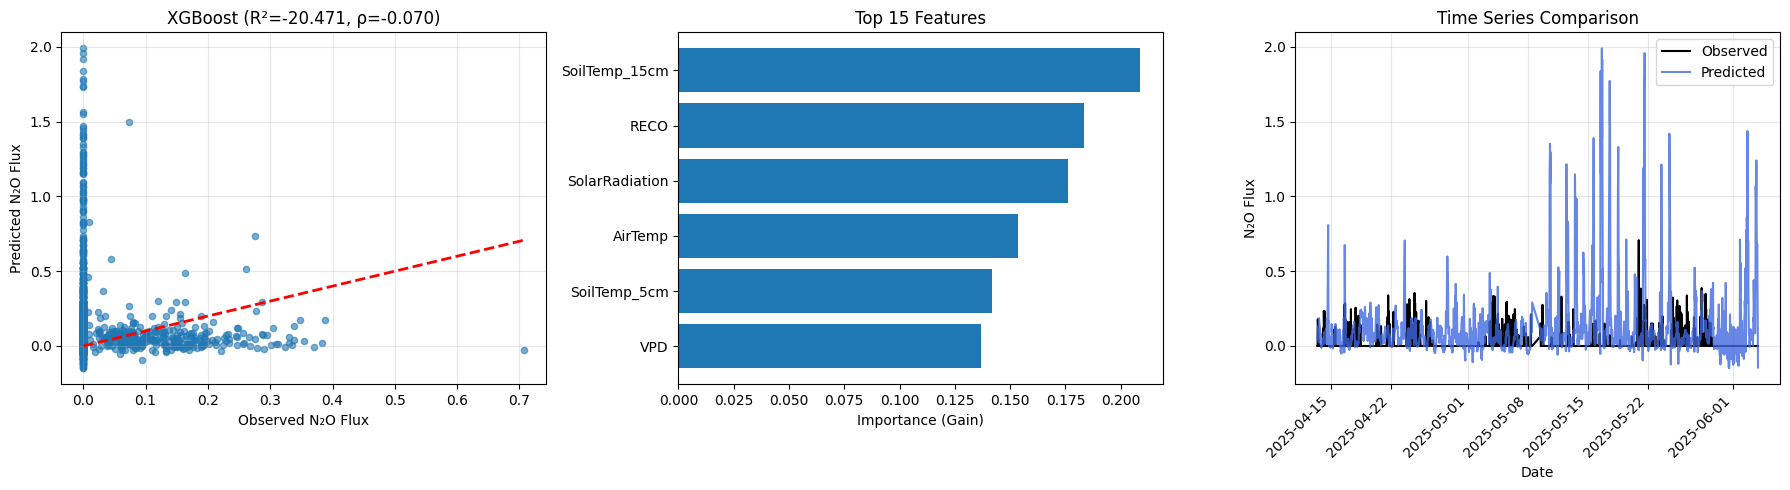


TOP 20 MOST IMPORTANT FEATURES:
SoilTemp_15cm     0.208637
RECO              0.183594
SolarRadiation    0.175940
AirTemp           0.153557
SoilTemp_5cm      0.141601
VPD               0.136670
dtype: float32


In [153]:
# ============================================================================
# TRAINING 1: forel_daily with lag features
# ============================================================================

print("--- Training on tanikon_daily | target=N2O_Flux_ln | predictors=lag ---")

results = train_xgb_timeseries(
    df=tanikon_daily,
    predictors=[
        # --- Meteorological base variables ---
        "Precipitation", "SolarRadiation", "AirTemp", "VPD",
        "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm",
        "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
        "NEE", "GPP", "RECO",

        # --- Meteorological lag variables ---
        "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
        "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
        "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
        "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
        "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
        "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
        "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
        "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
        "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
        "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
        "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
        "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
        "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",

        # --- Management variables ---
        "Mowing", "FertilizerOrganic", "FertilizerMineral",
        "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    ],
    target="N2O_Flux_ln",
)


# ============================================================================
# TRAINING 2: tanikon(hourly) with main columns only
# ============================================================================

print("\nmain cols")
results = train_xgb_timeseries(
    df=tanikon_lag,
    predictors=[
        "AirTemp", "VPD",
        "SoilTemp_5cm", "SoilTemp_15cm",
        "RECO", "SolarRadiation"
    ],
    target="N2O_Flux_ln",
)

# PRINT TOP FEATURES FROM LAST MODEL
print("\n" + "="*60)
print("TOP 20 MOST IMPORTANT FEATURES:")
print("="*60)
print(results["feature_importance"].head(20))